In [59]:
import csv
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO

from matplotlib import pyplot as plt


In [61]:
# def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MDI]")):
#     result = pattern.finditer(cigarstr)
#     cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
# #     output_str = "".join(["-" for i in range(cigar[1])])
#     output_str = ""
#     current_idx = 0
#     for item in cigar_seq:
#         if item[0]=="M":
#             added_str = querystr[current_idx:current_idx+item[1]]
#             output_str += added_str
#             current_idx += item[1]
#         elif item[0]=="D":
#             added_str = "".join(["-" for i in range(item[1])])
#             output_str += added_str
#         elif item[0]=="I":
#             current_idx += item[1]
#     return output_str

def cigarsfromsam(samfilepath):
    cigars = {}
    with open(samfilepath,"r") as samfile:
        for line in samfile:
            if line[0]=="@":
                next(samfile)
            else:
                splitline = line.split("\t")
                cigars[splitline[0]] = splitline[5]
    return cigars

def strsfromfasta(fastafilepath):
    queries = SeqIO.to_dict(SeqIO.parse(fastafilepath,"fasta"))
    queries = {key: str(val.seq) for key,val in queries.items()}
    return queries

def make_seg_dict(gfafile):
    segment_dict = {}
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                segment_dict[splitline[1]] = splitline[2][:-1]
    return segment_dict

def get_ref_intervals(gfafile):
    segment_dict = {}
    current_idx = 0
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                if "OFF" not in splitline[1]:
                    refstr = splitline[2][:-1]
                    strlen = len(refstr)
                    name = splitline[1]
                    if "ON" in name:
                        name=name[:-2]
                    segment_dict[name] = tuple((current_idx,current_idx+strlen))
                    current_idx += strlen
    return segment_dict
def align_read(querystr,refstr,cigarstr,startpos=1,pattern=re.compile("[0-9]{0,10}[MDI]")):
    start_pos = startpos-1 ##comes as 1 indexed from minimap
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    if start_pos > 0:
        output_str += "".join(["-" for i in range(start_pos)])
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    remaining_len = len(refstr)-len(output_str)
    if remaining_len>0:
        output_str += "".join(["-" for i in range(remaining_len)])
    return output_str

def splitstr(instr,ref_intervals):    
    strassign = {key:instr[val[0]:val[1]] for key,val in ref_intervals.items()}
    return strassign

def slow_hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

def get_dict_dist(dict1,dict2):
    hamming_dict = {key:slow_hamming_distance(dict1[key],dict2[key]) for key in dict1.keys()}
    return hamming_dict

In [4]:
R10_data = pd.read_csv("/home/de64/scratch/de64/2020-10-20_snakemake_2020-10-14_lDE11_R10-3_merged_final/output.tsv",delimiter="\t")
ref_intervals = get_ref_intervals("/home/de64/scratch/de64/2020-10-20_snakemake_2020-10-14_lDE11_R10-3_merged_final/ref.gfa")
R10_barcodes = set(R10_data["barcode"].tolist())

In [5]:
bit_arr = np.array([list(item) for item in R10_barcodes]).astype(int)
bit_freq = np.mean(bit_arr,axis=0)

In [6]:
len(bit_freq)

27

In [7]:
bit_arr

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 1]])

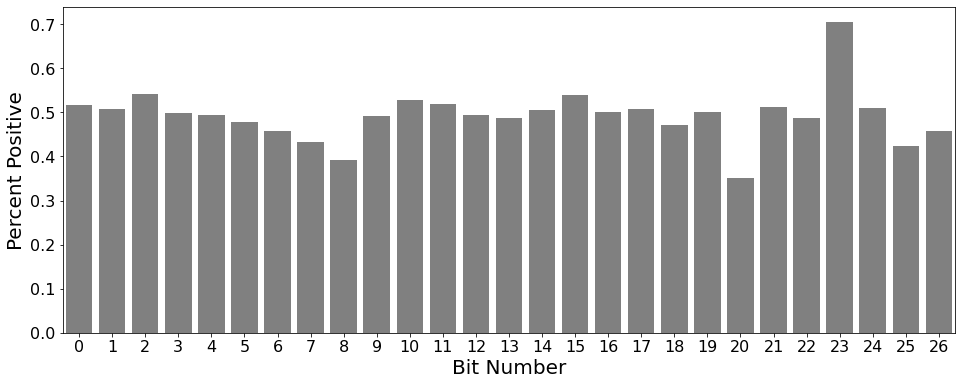

In [26]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(range(27)), y=bit_freq, color="grey")
plt.xlabel("Bit Number",fontsize=20)
plt.ylabel("Percent Positive",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("./figure_1.png",dpi=300,bbox_inches="tight")

In [23]:
both_on = bit_arr@bit_arr.T
both_off = (-bit_arr+1)@(-bit_arr.T+1)
ttl_match = both_on+both_off
np.fill_diagonal(ttl_match,100)

In [24]:
closest_match = np.min(ttl_match,axis=0)

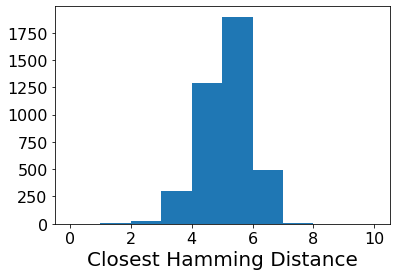

In [41]:
plt.hist(closest_match,range=(0,10))
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("./figure_2.png",dpi=300,bbox_inches="tight")

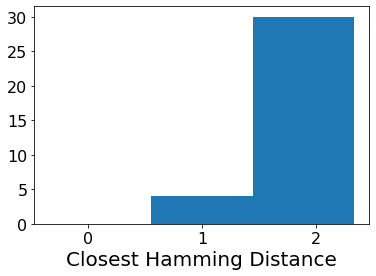

In [42]:
plt.hist(closest_match,range=(0,2),bins=3)
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.xticks([0.25,1.,1.75],[0,1,2],fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("./figure_3.png",dpi=300,bbox_inches="tight")

In [39]:
np.sum(closest_match==1)

4

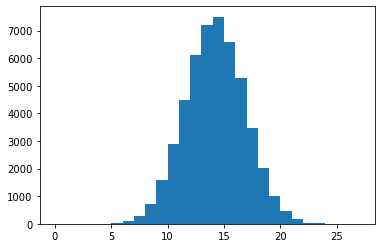

In [40]:
plt.hist(np.random.choice(ttl_match.flatten(),50000,replace=False),range=(0,27),bins=27)
plt.show()

In [45]:
aligned_cons = R10_data.apply(lambda x: align_read(x["consensus"],x["reference"],x["cigar"],startpos=x["alignmentstart"]), axis=1)
R10_data["aligned_cons"] = aligned_cons

split_ref = R10_data.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1)
split_align = R10_data.apply(lambda x: splitstr(x["aligned_cons"],ref_intervals), axis=1)
R10_data["split_ref"] = split_ref
R10_data["split_align"] = split_align

hamm_ref = R10_data.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1)
R10_data["hamm_ref"] = hamm_ref

dark_gfp = R10_data.apply(lambda x: slow_hamming_distance(x["split_align"]["GFP"][623:625],x["split_ref"]["GFP"][623:625]), axis=1)>0
R10_data["dark_gfp"] = dark_gfp

In [50]:
R10_data.to_csv("./lDE11_final_df.tsv",sep="\t")

#### Sanger Validation

In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt

record = SeqIO.read("./ab1_files/lDE11_validation_sample_1-oDE154.ab1", "abi")

In [26]:
def plot_sanger(seq_record,start=0,end=-1,figsize=(18,8)):
    fig = plt.figure(figsize=figsize)
    
    channels = ["DATA9", "DATA10", "DATA11", "DATA12"]
    trace = {}
    for c in channels:
        trace[c] = seq_record.annotations['abif_raw'][c]
        
    plt.plot(trace["DATA9"][start*10:end*10], color="blue")
    plt.plot(trace["DATA10"][start*10:end*10], color="red")
    plt.plot(trace["DATA11"][start*10:end*10], color="green")
    plt.plot(trace["DATA12"][start*10:end*10], color="yellow")
    plt.show()

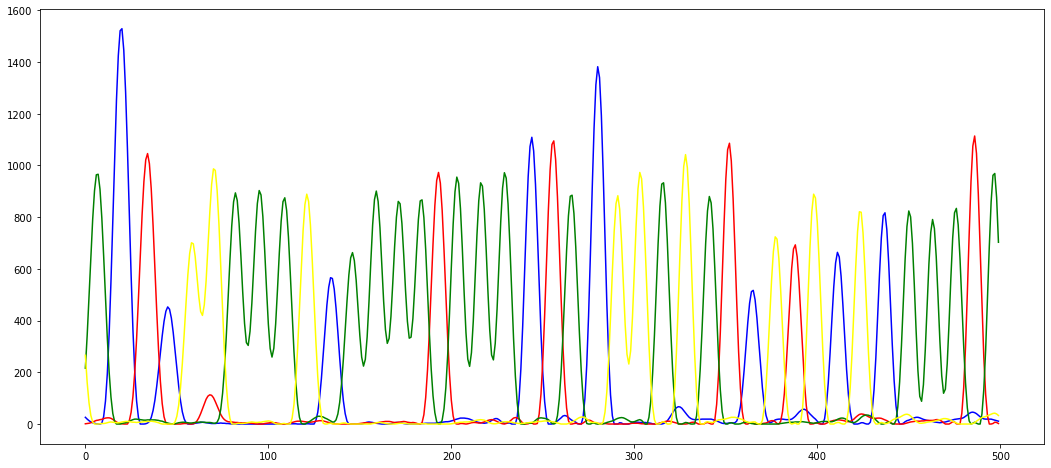

In [27]:
plot_sanger(record,50,100)

#### Convert to fastq and group

In [46]:
with open("./ab1_files/merged.fastq",'w') as outfile:
    for i in range(1,97):
        filepath1 = "./ab1_files/lDE11_validation_sample_" + str(i) + "-oDE154.ab1"
        filepath2 = "./ab1_files/lDE11_validation_sample_" + str(i) + "-oDE201.ab1"

        record1 = SeqIO.read(filepath1, "abi")
        record2 = SeqIO.read(filepath2, "abi")
        
        SeqIO.write(record1,outfile,"fastq")
        SeqIO.write(record2,outfile,"fastq")

In [49]:
!GraphAligner -g ./ref.gfa -f ./ab1_files/merged.fastq -a ./ab1_files/aligned.gaf -x dbg --high-memory -b 20 -B 35 -C -1

GraphAligner bioconda 1.0.12-
GraphAligner bioconda 1.0.12-
Load graph from ./ref.gfa
Build alignment graph
118 original nodes
150 split nodes
2 ambiguous split nodes
248 edges
100 nodes with in-degree >= 2
Build minimizer seeder from the graph
Minimizer seeds, length 19, window size 30, density 5
Seed cluster size 1
Extend up to best 0.002 fraction of seeds
Initial bandwidth 20, ramp bandwidth 35
write alignments to ./ab1_files/aligned.gaf
Align
Alignment finished
Input reads: 192 (193156bp)
Seeds found: 15017
Seeds extended: 192
Reads with a seed: 192 (193156bp)
Reads with an alignment: 192
Alignments: 192 (193156bp)
End-to-end alignments: 192 (193156bp)


In [82]:
import csv
import numpy as np

cigar_dict = {}
with open("./ab1_files/aligned.gaf", "r") as infile:
    for line in infile:
        data = line.split("\t")
        read_id = data[0].split(" ")[0]
        if ">" in data[5]:
            cigar_dict[read_id] = (
                "+",
                int(data[7]),
                int(data[8]),
                data[5],
                data[15].split(":")[-1][:-1],
            )
        else:
            cigar_dict[read_id] = (
                "-",
                int(data[7]),
                int(data[8]),
                data[5],
                data[15].split(":")[-1][:-1],
            )

barcode_dict = {}
for key in cigar_dict.keys():
    cigar = cigar_dict[key]
    if "oDE201" in key:
        barcode = cigar[3].split("<")
        barcode = barcode[::-1]
        barcode = barcode[:-1]
        barcode = (
            np.array(["ON" in item for item in barcode if "BIT" in item])
            .astype(int)
            .astype(str)
            .tolist()
        )
        barcode = "".join(barcode)
        index = key.split("_")[3].split("-")[0]
        barcode_dict[int(index)] = barcode
        
with open("./ab1_files/merged.fastq", "r") as infile:
    read_dict = SeqIO.parse(infile,"fastq")
    read_dict = SeqIO.to_dict(read_dict)

# barcode_dict = [
#     {"readname": key, "barcode": val, "cigar": cigar_dict[key]}
#     for key, val in barcode_dict.items()
# ]

# keys = ["readname", "barcode", "cigar"]
# with open(snakemake.output[0], "w") as outfile:
#     dict_writer = csv.DictWriter(outfile, keys, delimiter="\t")
#     dict_writer.writeheader()
#     dict_writer.writerows(barcode_dict)


In [75]:
cigar_dict['lDE11_validation_sample_1-oDE154'][4]

'9M1M1I8M1M1D571M1M1I1M1D315M1I32M1D9M1D8M'

In [69]:
barcode_dict[1]

'011101000101100111101100001'

In [57]:
cigar

('-',
 28,
 999,
 '<SPACER4<BIT26OFF<BIT25ON<BIT24OFF<BIT23OFF<BIT22OFF<SPACER3<BIT21OFF<BIT20OFF<BIT19OFF<BIT18OFF<BIT17ON<BIT16ON<SPACER2<BIT15ON<BIT14OFF<BIT13OFF<BIT12OFF<BIT11OFF<BIT10OFF<SPACER1<BIT9OFF<BIT8OFF<BIT7OFF<BIT6OFF<BIT5OFF<BIT4OFF<BIT3ON<BIT2ON<BIT1ON<BIT0ON<GFP',
 '971M')

In [63]:
R10_data = pd.read_csv("./lDE11_final_df.tsv",sep="\t")

In [71]:
R10_data[R10_data["barcode"] == barcode_dict[1]]

,Unnamed: 0,Unnamed: 0.1,barcodeid,barcode,consensus,reference,alignmentstart,cigar,subsample,aligned_cons,split_ref,split_align,hamm_ref,dark_gfp
1755,1755,1755,1755,011101000101100111101100001,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,1695M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'GFP': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAA...,{'GFP': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAA...,"{'GFP': 2, 'BIT0': 0, 'BIT1': 0, 'BIT2': 0, 'B...",True


In [147]:
all_snp_hamming = []
for i in range(1,97):
    if np.sum(R10_data["barcode"]==barcode_dict[i]) == 1:
        gfp_read_name = "lDE11_validation_sample_" + str(i) + "-oDE154"
        aligned = align_read(read_dict[gfp_read_name],R10_data[R10_data["barcode"] == barcode_dict[i]]["reference"].iloc[0],\
                             cigar_dict[gfp_read_name][4],startpos=cigar_dict[gfp_read_name][1]+1)
        ref_intervals = get_ref_intervals("./ref.gfa")
        split_ref = splitstr(R10_data[R10_data["barcode"] == barcode_dict[i]]["reference"].iloc[0],ref_intervals)
        split_consensus = splitstr(R10_data[R10_data["barcode"] == barcode_dict[i]]["consensus"].iloc[0],ref_intervals)
        split_align = splitstr(str(aligned.seq),ref_intervals)
        snp_hamming = slow_hamming_distance(split_align["GFP"][623:625],split_consensus["GFP"][623:625])
        all_snp_hamming.append(snp_hamming)

(array([ 0.,  0.,  0.,  0.,  0., 93.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

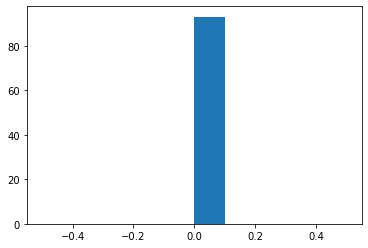

In [145]:
plt.hist(all_snp_hamming)

In [139]:
ttl_bc = []
for i in range(1,97):
    ttl_bc.append(np.sum(R10_data["barcode"]==barcode_dict[i]))

In [141]:
np.sum(ttl_bc)

93

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 93.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

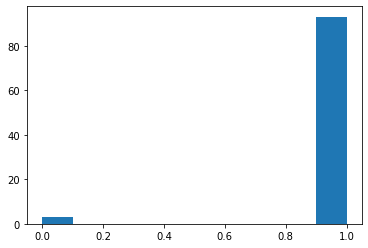

In [136]:
plt.hist(ttl_bc)

In [125]:
R10_data[R10_data["barcode"] == barcode_dict[i]]

,Unnamed: 0,Unnamed: 0.1,barcodeid,barcode,consensus,reference,alignmentstart,cigar,subsample,aligned_cons,split_ref,split_align,hamm_ref,dark_gfp


In [138]:
len("011101000101100111101100001")

27

In [115]:
split_align["GFP"][623:625]

'TA'

In [116]:
split_ref["GFP"][623:625]

'AT'

In [118]:
split_consensus["GFP"][623:625]

'TA'

In [119]:
slow_hamming_distance(split_align["GFP"][623:625],split_consensus["GFP"][623:625])

0